# Train a JointVAE model

### Get MNIST data
Build a simple JointVAE model on MNIST

In [106]:
VAE_TRAIN = False
FIND_DIST = False
FOLDER = "dist1"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [33]:
from dataloaders import get_mnist_dataloaders_attack, get_mnist_dataloaders
# train_loader, test_loader = get_mnist_dataloaders_attack(2, 5, train_batch_size=64, test_batch_size=64, path_to_data='/home/data/bvaa')
train_loader, test_loader = get_mnist_dataloaders(batch_size=64, path_to_data='/home/data/bvaa')

In [4]:
from torchvision import datasets, transforms
all_transforms = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor()
    ])
train_data = datasets.MNIST('/home/data/bvaa/', train=True, download=True,
                                transform=all_transforms)

### Define latent distribution of the model

In [5]:
# Latent distribution will be joint distribution of 10 gaussian normal distributions
# and one 10 dimensional Gumbel Softmax distribution
latent_spec = {'cont': 15,
               'disc': [15]}
latent_dim = 30

### Build a model

In [6]:
from models import VAE

model = VAE(latent_spec=latent_spec, img_size=(1, 32, 32), use_cuda=True).cuda()

### Train the model

In [7]:
from torch import optim

# Build optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-4)

In [8]:

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.softmax(x, dim=1)
        return output

classifier = Classifier().cuda()
classifier.load_state_dict(torch.load('../VAE/models/mnist_cnn_non_log.pt'))

<All keys matched successfully>

In [9]:
from training import Trainer

# Define the capacities
# Continuous channels
cont_capacity = [0.0, 6.0, 25000, 30.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0
# Discrete channels
disc_capacity = [0.0, 6.0, 25000, 30.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0

# Build a trainer
trainer = Trainer(model, optimizer,
                  cont_capacity=cont_capacity,
                  disc_capacity=disc_capacity, use_cuda=True)

In [10]:
# # Build a visualizer which will be passed to trainer to visualize progress during training
# from visualize import Visualizer

# viz = Visualizer(model)

In [10]:
# Train model for 10 epochs
# Note this should really be a 100 epochs and trained on a GPU, but this is just to demo

# trainer.train(train_loader, epochs=100, save_training_gif=('./training.gif', viz))
if VAE_TRAIN:
    trainer.train(train_loader, epochs=100)
    torch.save(model.state_dict(), 'models/vae_new.pth')
else:
    model.load_state_dict(torch.load('models/vae_new.pth'))
    model.eval()

## Digits

In [11]:
from torchvision import datasets, transforms
all_transforms = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor()
    ])
train_data = datasets.MNIST('/home/data/bvaa/', train=True, download=True,
                                transform=all_transforms)

In [12]:
list_index = {}
for i in range(len(train_data)):
    index = train_data[i][1]
    if index not in list_index.keys():
        list_index[index] = [i]
    else:
        list_index[index].append(i)

In [13]:
from tqdm.notebook import tqdm
l_sample_list = {}
def get_average_latent_space(list_index):
    for i in tqdm(list_index.keys()):
        for j in list_index[i]:
            output, l_dist = model(train_data[j][0].unsqueeze(0).cuda())
            l_sample_x = model.reparameterize(l_dist)
            if i not in l_sample_list.keys():
                l_sample_list[i] = [l_sample_x]
            else:
                l_sample_list[i].append(l_sample_x)
        l_sample_list[i] = {'mean':torch.mean(torch.stack(l_sample_list[i]), dim=0),
                           'std':torch.std(torch.stack(l_sample_list[i]), dim=0)}
        
get_average_latent_space(list_index)

In [14]:
import math

In [356]:
def check_distribution(digit, plot=False):
    alpha = torch.clamp(torch.randn(l_sample_list[digit]['std'].shape).cuda(), min=-0.8, max=0.8)
    test_sample = l_sample_list[digit]['mean'] + F.normalize(alpha)*l_sample_list[digit]['std']
    test = model.decode(test_sample)
    preds = torch.argmax(classifier(F.upsample(test, (28,28), mode='bilinear', align_corners=True)))
#     print(preds.item())
    if plot:
        plt.imshow(model.decode(test_sample)[0,0].cpu().detach().numpy(), cmap='gray', interpolation='none')
    return test_sample

In [469]:
def digits_add(digit1, digit2, alpha=1, plot=False):
    l_1 = check_distribution(digit1)
    l_2 = check_distribution(digit2)
    if plot:
        test = model.decode(l_1+alpha*l_2)
        plt.imshow(test[0,0].cpu().detach().numpy(), cmap='gray', interpolation='none')
        preds = torch.argmax(classifier(F.upsample(test, (28,28), mode='bilinear', align_corners=True)))
        print(preds.item())
    return torch.norm(l_1-l_2), l_1, l_2

In [430]:
def get_avg_dist(digit1, digit2, exp=10000):
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    distance = []
    similarity = []
    for i in range(exp):
        dist, l1, l2 = digits_add(digit1,digit2)
        similar = cos(l1,l2)
        distance.append(dist.item())
        similarity.append(similar.item())
    a = round(sum(distance)/len(distance),5)
    b = round(sum(similarity)/len(similarity),5)
    return a,b

In [431]:
get_avg_dist(1,3)

(1.41276, -0.00568)

In [432]:
get_avg_dist(1,2)

(1.39573, 0.05866)

In [433]:
get_avg_dist(2,3)

(1.35139, -0.00226)

3


(tensor(1.3075, device='cuda:0', grad_fn=<NormBackward0>),
 tensor([[ 0.0993,  0.0288, -0.0692, -0.0151, -0.0064,  0.3087, -0.0971, -0.0517,
           0.0244,  0.0205, -0.0434,  0.2887,  0.0903, -0.1277,  0.0282,  0.1995,
          -0.0061,  0.7159,  0.0234, -0.0029,  0.0000, -0.0057, -0.0018, -0.0026,
           0.0021,  0.0033, -0.0032,  0.0043, -0.0078,  0.0242]],
        device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[ 0.0671, -0.5320, -0.0803, -0.0159, -0.0027, -0.0955, -0.0862, -0.4387,
           0.0206,  0.0037, -0.0479, -0.1137,  0.1245,  0.0995,  0.0097,  0.5153,
          -0.0018,  0.0207, -0.0086,  0.0147,  0.0000, -0.0073,  0.0299, -0.0024,
          -0.0061,  0.0470, -0.0015, -0.0072, -0.0088,  0.5512]],
        device='cuda:0', grad_fn=<AddBackward0>))

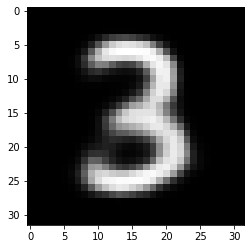

In [478]:
digits_add(2,3,0.8,True)

1


(tensor(1.3860, device='cuda:0', grad_fn=<NormBackward0>),
 tensor([[ 1.9513e-01,  1.2040e-01, -1.1070e-01, -6.5339e-04, -1.3995e-03,
           6.9410e-02,  3.5706e-02, -1.1764e-01, -1.1523e-03, -1.1181e-03,
           6.9419e-02,  2.4323e-02,  1.3775e-01, -2.7503e-02,  8.9314e-03,
           3.6572e-02,  0.0000e+00, -1.5762e-03, -2.7700e-03,  1.5285e-02,
           0.0000e+00,  1.4007e-02, -9.2873e-03,  7.2654e-03,  0.0000e+00,
           3.0667e-03,  9.6276e-01,  2.6306e-03,  0.0000e+00, -1.3399e-02]],
        device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[-1.6292e-01, -2.3662e-01, -8.7184e-02, -1.4093e-02, -2.8299e-03,
           1.2268e-01, -9.6697e-02, -3.9539e-01,  1.9913e-02,  6.2017e-03,
          -4.7740e-02,  5.1885e-02,  1.3465e-01,  9.2152e-02,  9.6169e-03,
           5.6544e-01,  1.0208e-03,  1.8266e-02,  3.8801e-03,  1.1925e-02,
           0.0000e+00,  6.6198e-02,  2.9887e-02,  1.7356e-03, -9.2245e-04,
          -1.3489e-02, -4.3649e-04, -6.4890e-03,  2.3924e-02,  5

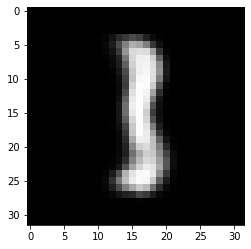

In [455]:
digits_add(1,3,True)

9


(tensor(1.3275, device='cuda:0', grad_fn=<NormBackward0>),
 tensor([[ 3.5711e-01,  3.8470e-02, -1.1104e-01,  8.8817e-04, -1.2720e-03,
          -2.2189e-02,  3.1700e-02,  2.7286e-01, -5.6709e-04,  2.5682e-03,
           6.7551e-02,  6.0846e-03,  1.3475e-01, -2.7054e-02,  7.1401e-03,
           3.3394e-02,  0.0000e+00,  1.3334e-02,  2.7739e-03,  2.0086e-02,
           0.0000e+00, -8.8991e-03, -8.1173e-03, -5.1275e-03,  0.0000e+00,
           2.7739e-03,  9.4948e-01,  7.3352e-03,  0.0000e+00,  2.7551e-02]],
        device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[ 0.3585, -0.0126, -0.0694, -0.0168, -0.0033,  0.0702, -0.0971,  0.2538,
           0.0244,  0.0129, -0.0437,  0.0559,  0.0817, -0.1688,  0.0283,  0.1242,
           0.0036,  0.9047,  0.0153, -0.0030,  0.0000,  0.0146,  0.0152,  0.0038,
           0.0130,  0.0014,  0.0078,  0.0157,  0.0032, -0.0125]],
        device='cuda:0', grad_fn=<AddBackward0>))

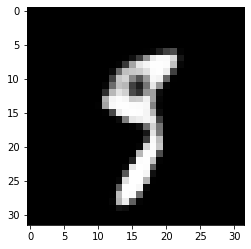

In [445]:
digits_add(1,2,True)

In [451]:
def digit_to_study(digit):
    distance = {}
    similarity = {}
    for i in tqdm(range(10)):
        distance[i], similarity[i] = get_avg_dist(digit,i)
    return distance, similarity

In [452]:
digit_to_study(1)

({0: 1.5251,
  1: 0.38867,
  2: 1.39411,
  3: 1.41402,
  4: 1.425,
  5: 1.86698,
  6: 1.6335,
  7: 1.34959,
  8: 1.43038,
  9: 1.41897},
 {0: 0.0479,
  1: 0.92858,
  2: 0.06044,
  3: -0.00621,
  4: 0.01815,
  5: -0.11013,
  6: 0.09571,
  7: 0.019,
  8: 0.15734,
  9: 0.07422})

In [453]:
digit_to_study(2)

/opt/miniconda3/envs/bvaa/lib/python3.6/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


({0: 1.54157,
  1: 1.39567,
  2: 0.5584,
  3: 1.35081,
  4: 1.33102,
  5: 1.78764,
  6: 1.48036,
  7: 1.26946,
  8: 1.41637,
  9: 1.39319},
 {0: -0.04053,
  1: 0.0581,
  2: 0.83352,
  3: -0.00146,
  4: 0.06947,
  5: -0.07606,
  6: 0.22005,
  7: 0.04831,
  8: 0.11409,
  9: 0.0346})

2


/opt/miniconda3/envs/bvaa/lib/python3.6/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


tensor([[ 2.4842e-01,  1.7054e-01, -6.6872e-02, -1.6619e-02, -4.3819e-03,
         -1.2319e-01, -1.0822e-01,  2.5248e-01,  1.6345e-02,  1.3451e-02,
         -4.3950e-02,  2.4825e-01,  8.7654e-02,  3.0910e-02,  2.7175e-02,
          8.8651e-02,  7.7721e-03,  9.0391e-01,  2.3308e-02,  3.2693e-03,
          0.0000e+00,  8.9162e-03, -3.0079e-03,  6.8728e-03, -1.4079e-02,
         -6.0601e-04, -3.5186e-03, -9.9173e-03,  1.0809e-02, -1.2422e-02]],
       device='cuda:0', grad_fn=<AddBackward0>)

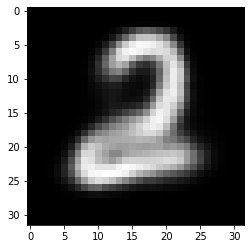

In [336]:
check_distribution(2)

In [17]:
if FIND_DIST is True:
    l_means = []
    l_stds = []
    for i in l_sample_list.keys():
        l_means.append(l_sample_list[i]['mean'])
        l_stds.append(l_sample_list[i]['std'])

    l_mean_tensor = torch.stack(l_means).squeeze(1)
    # print(l_mean_tensor.shape)

    l_std_tensor = torch.stack(l_stds).squeeze(1)
    # print(l_std_tensor.shape)

    torch.save(l_mean_tensor, 'tensor/latent_mean.pt')
    torch.save(l_std_tensor, 'tensor/latent_std.pt')

else:
    l_mean_tensor = torch.load('tensor/latent_mean.pt')
    l_std_tensor = torch.load('tensor/latent_std.pt')

In [18]:
l_mean_tensor.shape

torch.Size([10, 30])

## Attack

In [19]:
attack_digit = 2
target_digit = 5

### Visualize

In [34]:
examples = enumerate(test_loader)
batch_idx, (example_data,target) = next(examples)

In [146]:
# def plot_64(data):
#     l_sample = None
#     for i in range(data.shape[0]):
#         output, l_dist_x = model(data[i,:,:,:].unsqueeze(0).cuda())
#         l_sample_x = model.reparameterize(l_dist_x)
#         if l_sample is None:
#             l_sample = l_sample_x
#         else:
#             l_sample += l_sample_x
#     l_sample = l_sample / data.shape[0]
#     new_output = model.decode(l_sample)
#     plt.imshow(new_output[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
#     pred = classifier(F.upsample(new_output, (28,28), mode='bilinear', align_corners=True))
#     print(pred)
#     print(torch.argmax(pred))
#     return l_sample

In [147]:
# def get_batch_avg(data):
#     l_sample = None
#     for i in range(data.shape[0]):
#         output, l_dist_x = model(data[i,:,:,:].unsqueeze(0).cuda())
#         l_sample_x = model.reparameterize(l_dist_x)
#         if l_sample is None:
#             l_sample = l_sample_x
#         else:
#             l_sample += l_sample_x
#     l_sample = l_sample / data.shape[0]
# #     new_output = model.decode(l_sample)
# #     plt.imshow(new_output[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
# #     pred = classifier(F.upsample(new_output, (28,28), mode='bilinear', align_corners=True))
# #     print(pred)
# #     print(torch.argmax(pred))
#     return l_sample

In [148]:
# def plot_avg_mnist(img1, data):
# #     new_l_sample = None
# #     count = len(list_to_process)
#     output, l_dist_x = model(img1.cuda())
#     l_sample_x = model.reparameterize(l_dist_x)
#     l_sample_y = get_batch_avg(data)
# #     output, l_dist_y = model(img2.cuda())
# #     l_sample_y = model.reparameterize(l_dist_y)
    
#     l_sample = 1*l_sample_x + 0.4*l_sample_y
    
#     new_output = model.decode(l_sample)
# #     for i in list_to_process:
# #         example_img = example_data[i,:,:,:].unsqueeze(0).cuda()
# #         output, l_dist = model(example_img)
# #         l_sample = model.reparameterize(l_dist)
# #         if new_l_sample is None:
# #             new_l_sample = l_sample
# #         else:
# #             new_l_sample += l_sample
# #     new_l_sample = new_l_sample / count
# #     new_output = model.decode(new_l_sample)
#     plt.imshow(new_output[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
#     pred = classifier(F.upsample(new_output, (28,28), mode='bilinear', align_corners=True))
#     print(pred)
#     print(torch.argmax(pred))
#     print(pred[0,2].item(), pred[0,5].item())

In [149]:
# def plot_mnist(list_to_process):
#     new_l_sample = None
#     count = len(list_to_process)
#     for i in list_to_process:
#         example_img = example_data[i,:,:,:].unsqueeze(0).cuda()
#         output, l_dist = model(example_img)
#         l_sample = model.reparameterize(l_dist)
#         if new_l_sample is None:
#             new_l_sample = l_sample
#         else:
#             new_l_sample += l_sample
#     new_l_sample = new_l_sample / count
#     new_output = model.decode(new_l_sample)
#     plt.imshow(new_output[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')

In [35]:
def check(i, j, alpha, beta):
    im1 = example_data[i,:,:,:].unsqueeze(0).cuda()
    im2 = example_data[j,:,:,:].unsqueeze(0).cuda()
    out1, l_dist1 = model(im1)
    out2, l_dist2 = model(im2)
    l_sample1 = model.reparameterize(l_dist1)
    l_sample2 = model.reparameterize(l_dist2)
    l_sample = alpha*l_sample1 + beta*l_sample2
    new_out = model.decode(l_sample)
#     new_out1 = model.decode(l_sample1)
#     new_out2 = model.decode(l_sample2)
    plt.figure(figsize=(10,15))
    plt.subplot(1,3,1)
    plt.imshow(example_data[i][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
    plt.subplot(1,3,2)
    plt.imshow(example_data[j][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
    plt.subplot(1,3,3)
    plt.imshow(new_out[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
    print(torch.argmax(classifier(F.upsample(new_out, (28,28), mode='bilinear', align_corners=True))))

tensor(0, device='cuda:0')


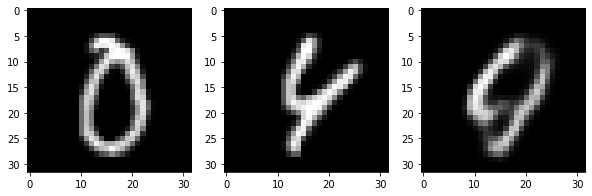

In [36]:
alpha=1
beta = 1.2
check(19,11, alpha, beta)

In [12]:
# class Attack(nn.Module):
#     def __init__(self, attack_digit=attack_digit, target_digit=target_digit, vae=model, classifier=classifier, avg_latent=l_sample_list):
#         super(self, Attack).__init__()
#         self.classifier = classifier
#         self.classifier.eval()
#         self.vae = vae
#         self.vae.eval()
#         self.avg_latent = avg_latent
#         self.attack_digit = attack_digit
#         self.target_digit = target_digit
#         self.hidden_layers = hidden_layers
#         self.hidden_layers.insert(0, latent_dim)
#         self.hidden_layers.append(latent_dim)
#         self.layers = []
        
#         for i in range(len(self.hidden_layers)-1):
#             self.layers.append(nn.Linear(self.hidden_layers[i], self.hidden_layers[i+1]))
        
#         self.layers = nn.ModuleList(self.layers)
        
#     def forward(self, x, y):
#         _, l_dist_x = self.vae(x)
#         _, l_dist_y = self.vae(y)
#         l_sample_x = self.vae.reparameterize(l_dist_x)
#         l_sample_y = self.vae.reparameterize(l_dist_y)
#         noised_sample = l_sample
#         for layer in self.layers:
#             noised_sample = layer(noised_sample)
#         noised_images = self.vae.decoder(noised_sample)
#         preds = self.classifier(F.upsample(noised_image, (28,28), mode='bilinear', align_corners=True))
#         return x

In [24]:
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = torch.Tensor(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

ssim_loss = SSIM(window_size = 5)

In [457]:
use_cuda = True
device = torch.device('cuda' if use_cuda else 'cpu')

# Constrained Translator
class Noise(nn.Module):
    def __init__(self, hidden_layers=[100, 200, len(train_data.classes)*latent_dim], latent_dim=latent_dim):
        super(Noise, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_layers = hidden_layers
        self.hidden_layers.insert(0, latent_dim)
        self.layers = []
        
        for i in range(len(self.hidden_layers)-1):
            self.layers.append(nn.Linear(self.hidden_layers[i], self.hidden_layers[i+1]))
        
        self.layers = nn.ModuleList(self.layers)
        
    def forward(self, x):
        l_sample = x
        for layer in self.layers:
            x = layer(x)
        coff = x
#         final = torch.zeros((x.shape[0], self.latent_dim))
#         for i in range(final.shape[0]):
#             z = torch.zeros((1, self.latent_dim))
#             count = 0
#             for j in coff[i,:].tolist():
#                 z += j * self.avg_latent[count].cpu()
#                 count += 1
#             final[i] = z
#         noised_sample = l_sample +  final.cuda()
        return coff

In [458]:
# Constrained Cofficients
class Cofficients(nn.Module):
    def __init__(self, hidden_layers=[50, 40, 30, 20, len(train_data.classes)], latent_dim=latent_dim):
        super(Cofficients, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_layers = hidden_layers
        self.hidden_layers.insert(0, latent_dim)
        self.layers = []
        
        for i in range(len(self.hidden_layers)-1):
            self.layers.append(nn.Linear(self.hidden_layers[i], self.hidden_layers[i+1]))
        
        self.layers = nn.ModuleList(self.layers)
        
    def forward(self, x):
        l_sample = x
        for layer in self.layers:
            x = layer(x)
        coff = x
#         final = torch.zeros((x.shape[0], self.latent_dim))
#         for i in range(final.shape[0]):
#             z = torch.zeros((1, self.latent_dim))
#             count = 0
#             for j in coff[i,:].tolist():
#                 z += j * self.avg_latent[count].cpu()
#                 count += 1
#             final[i] = z
#         noised_sample = l_sample +  final.cuda()
        return coff

In [459]:
# from skimage.metrics import structural_similarity as ssim

use_cuda = True
device = torch.device('cuda' if use_cuda else 'cpu')


def create_logits(target_label, pred, confidence=0.45, device=device):
    logits = torch.zeros(pred.shape, dtype=torch.float64)
    pred_labels = [int(element.item()) for element in torch.argmax(pred, dim=1)]
#     print("length", len(pred_labels))
#     print("pred_lables:",pred_labels)
#     print(logits.shape)
    logits[range(logits.shape[0]), pred_labels] = torch.DoubleTensor([1-confidence]*pred.shape[0])
    logits[range(logits.shape[0]), [target_label]*pred.shape[0]] += torch.DoubleTensor([confidence]*pred.shape[0])
#     print(logits[0])
    return logits.to(device)

def structural(org_image, noised_image):
    batch_size, channels, width, height = org_image.shape
    loss1 = 0
    for b_ in range(batch_size):
        ch_loss = 0
        for ch_ in range(channels):
            ch_loss += 1-ssim(org_image[b_][ch_].detach().cpu().numpy(), noised_image[b_][ch_].detach().cpu().numpy())
        loss1 += ch_loss/channels
    return loss1
            
class T_Loss(nn.Module):
    def __init__(self, decoder=model.decode, classifier=classifier,
                 latent_dim=latent_dim, means=l_mean_tensor, stds=l_std_tensor,
                 classes=len(train_data.classes)):
        super(T_Loss, self).__init__()
        self.decoder = decoder
        self.classifier = classifier
        self.means = means
        self.stds = stds
        self.classes = classes
        self.latent_dim = latent_dim
    def forward(self, coffs, noises, org_x, target_label):
        org_image = self.decoder(org_x)
        noise_latent = self.means + F.normalize(noises.reshape(noises.shape[0], self.classes, self.latent_dim))*self.stds
        noise_latent = F.normalize(coffs[:,:,None])*noise_latent
#         noise_latent = torch.clamp(coffs[:,:,None]*noise_latent, min=-0.5, max=0.5)
#         print(noise_latent.max())
#         print(noise.shape)
#         print(org_x.shape)
#         noise = torch.transpose(torch.clamp(coff[:,None].cuda(), min=-0.8, max=0.3)*self.avg_latent.T, 1, 2).sum(1)
#         noise = torch.clamp(noise, min=-0.2, max=0.2)
#         final = torch.zeros(org_x.shape)
#         for i in range(final.shape[0]):
#             z = torch.zeros((1, self.latent_dim))
#             count = 0
#             for j in coff[i,:].tolist():
#                 z += j * self.avg_latent[count].cpu()
#                 count += 1
#             final[i] = z
        noised_sample = org_x +  0.3*noise_latent.sum(dim=1)
        noised_image = self.decoder(noised_sample)
        batch_size, channels, width, height = org_image.shape
        loss1 = ssim_loss(org_image, noised_image)
#         print(type(loss1))
#         print(loss1)
#         loss1 = torch.Tensor(loss1 / batch_size).to(device)
#         print("loss1:", loss1)
        preds = self.classifier(F.upsample(noised_image, (28,28), mode='bilinear', align_corners=True))

        target = create_logits(target_label, preds)

        loss2 = nn.BCELoss(reduction='sum')(preds, target.float())
        
        loss3 = torch.norm(org_image-noised_image, p=2)  
#         print(loss3)
#         print(loss2)
#         print(loss1)
#         print(400*(1-loss1))
#         print(loss2)
#         loss = 400*(1-loss1) + 0.5*loss2 + 20*loss3
        loss = 0.5*loss2 + 20*loss3
#         loss = loss2 + 20*loss3
        
        
        out_labels = preds.argmax(dim=1, keepdim=True)
#         print(out_labels)
#         print(torch.empty(out_labels.shape).fill_(target_label))
#         print(preds)
#         correct = out_labels.eq(torch.Tensor([target_label]*out_labels.shape[0]).to(device)).sum()
        correct = out_labels.eq(torch.empty(out_labels.shape).fill_(target_label).to(device)).sum()
#         print(out_labels.shape)
#         print(correct)
#         print(torch.Tensor([target_label]*out_labels.shape[0]))
#         print(out_labels)
        return loss, correct.item()

In [460]:
noise = Noise().to(device)
cofficient = Cofficients().to(device)
tloss = T_Loss().to(device)
tloss.eval()

T_Loss(
  (classifier): Classifier(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (dropout1): Dropout2d(p=0.25, inplace=False)
    (dropout2): Dropout2d(p=0.5, inplace=False)
    (fc1): Linear(in_features=9216, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [468]:
count_digit = 0
for i in range(len(train_data)):
    if train_data[i][1]==5:
        count_digit += 1
print(count_digit)

5421


In [461]:
from tqdm.notebook import tqdm
attack_log_interval = 1
alt_target = 5
noise.train()
cofficient.train()
# optimizer1 = optim.Adam(noise.parameters(), lr=1e-7)
optimizer2 = optim.Adam(cofficient.parameters(), lr=1e-7)

optimizer1 = torch.optim.SGD(noise.parameters(), lr=1e-7, momentum=0.9)
# optimizer2 = torch.optim.SGD(cofficient.parameters(), lr=1e-5, momentum=0.9)

scheduler1 = torch.optim.lr_scheduler.CyclicLR(optimizer1, base_lr=1e-7, max_lr=0.1)
# scheduler2 = torch.optim.lr_scheduler.CyclicLR(optimizer2, base_lr=1e-7, max_lr=0.1)

for epoch in tqdm(range(450)):
    epoch_loss = 0
    epoch_correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer1.zero_grad()
        optimizer2.zero_grad()
#         print(target)
        data = torch.FloatTensor(data).to(device)
        
        _, l_dist = model(data)
        l_sample = model.reparameterize(l_dist)
        
        noise_ = noise(l_sample)
        coff_ = cofficient(l_sample)
        loss, correct = tloss(coff_, noise_, l_sample, alt_target)
        loss.backward()
        
        optimizer1.step()
        optimizer2.step()
        
        scheduler1.step()
#         scheduler2.step()
#         print(correct)
        epoch_loss += loss.item()
    
        epoch_correct += correct
        
    if (epoch+1) % attack_log_interval == 0:
        print('Train Epoch: {}\tLoss: {:.6f}\tCorrect: {}'.format(
            epoch+1, epoch_loss/batch_idx, epoch_correct))

Train Epoch: 1	Loss: 557.739248	Correct: 4928


KeyboardInterrupt: 

In [107]:
torch.save(noise, 'models/{}/noise.pt'.format(FOLDER))
torch.save(cofficient, 'models/{}/coff.pt'.format(FOLDER))

/opt/miniconda3/envs/bvaa/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Noise. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/miniconda3/envs/bvaa/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Cofficients. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [152]:
noise.eval()
cofficient.eval()
total_correct = 0
total_test = 0
for batch_idx, (data, target) in enumerate(test_loader):
    total_test += data.shape[0]
    data = torch.FloatTensor(data).to(device)

    _, l_dist = model(data)
    l_sample = model.reparameterize(l_dist)
    
    noise_ = noise(l_sample)
    coff_ = cofficient(l_sample)
    
    loss, correct = tloss(coff_, noise_, l_sample, alt_target)
    total_correct += correct
#     print(correct)
#         loss.backward()
#         optimizer.step()
#         print(correct)
#         epoch_loss += loss.item()
    

#     if (epoch+1) % attack_log_interval == 0:
#         print('Train Epoch: \tCorrect: {}'.format(
#             epoch, epoch_correct))
print(total_correct)
print("Accuracy: ", 100*(total_correct/total_test))

867
Accuracy:  8.67


In [157]:
def test(i, means=l_mean_tensor, stds=l_std_tensor, latent_dim=latent_dim, classes=len(train_data.classes)):
    _, l_dist = model(example_data[i].unsqueeze_(0).to(device))
    l_sample = model.reparameterize(l_dist)
    noises = noise(l_sample)
    coffs = cofficient(l_sample)
#     print(coffs.shape)
#     print(noises.shape)
    noised_latent = means + noises.reshape(noises.shape[0], classes, latent_dim)*stds
    noised_latent = coffs[:,:,None]*noised_latent
#     print(noised_latent.shape)
#     print(l_sample.shape)
#     print(torch.transpose(coff[:,None].cuda()*avg_latent.T, 1, 2).sum(1).shape)
#     noised_latent = l_sample + 2e-1*torch.transpose(coff[:,None].cuda()*avg_latent.T, 1, 2).sum(1)
#     print(noised_latent.shape)
#     print(noised_sample)
#     print(l_sample)
#     noised_sample = 1 * ((l_sample - l_sample.min())/(l_sample.max() - l_sample.min())) + 1e-2 * ((noised_sample - noised_sample.min())/(noised_sample.max() - noised_sample.min()))
#     noised_sample = 1 * l_sample + 2e-2 * noised_sample
#     noised_sample = l_sample + 1e-7 * noised_sample
    final = model.decode(l_sample+1e-12*noised_latent.sum(dim=1))
#     print(final.shape)
    pred_org = torch.argmax(classifier(F.upsample(example_data[i,:,:,:].unsqueeze(0).cuda(), (28,28), mode='bilinear', align_corners=True)))
    pred = torch.argmax(classifier(F.upsample(final, (28,28), mode='bilinear', align_corners=True)), dim=1)
#     print(pred)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(example_data[i][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
    plt.subplot(1,2,2)
    plt.imshow(final[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
    plt.title("Prediction: {}, {}".format(pred_org.item(), pred.item()))

/opt/miniconda3/envs/bvaa/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


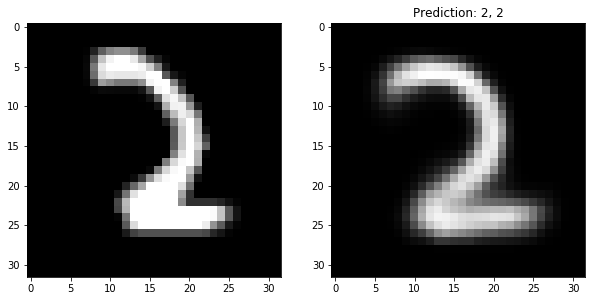

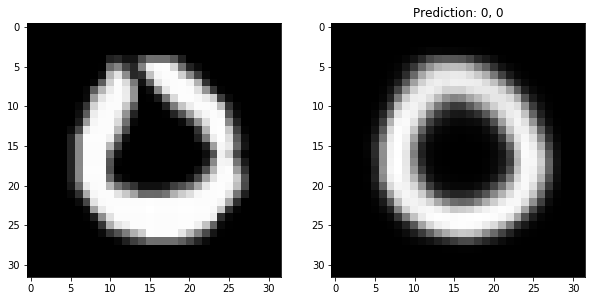

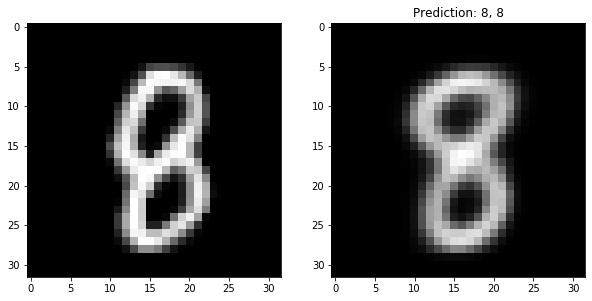

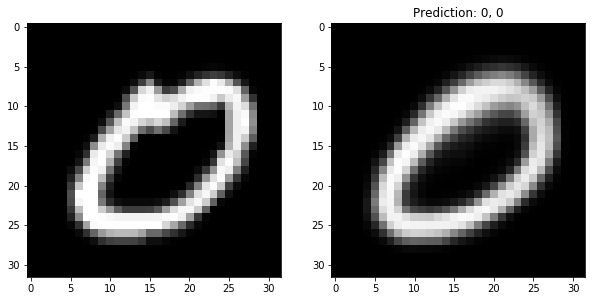

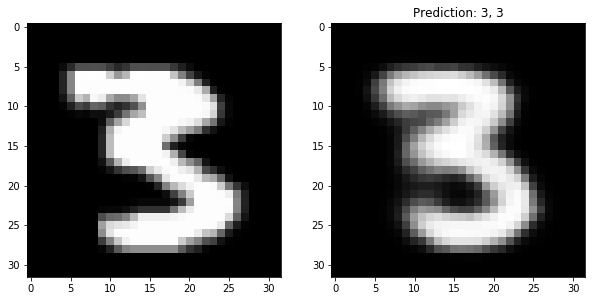

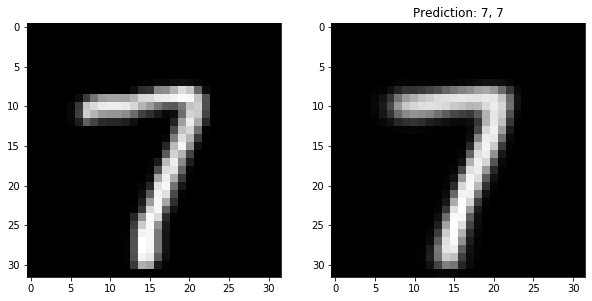

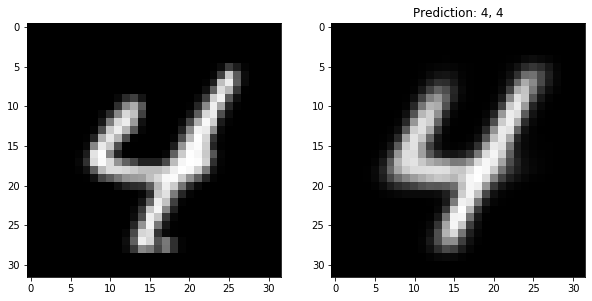

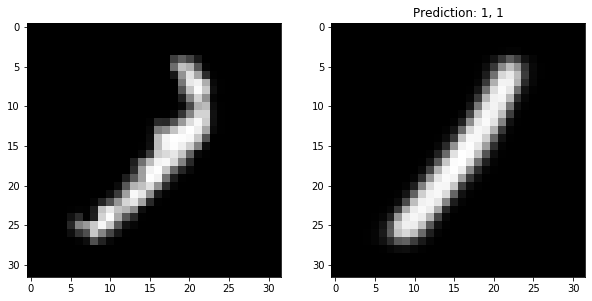

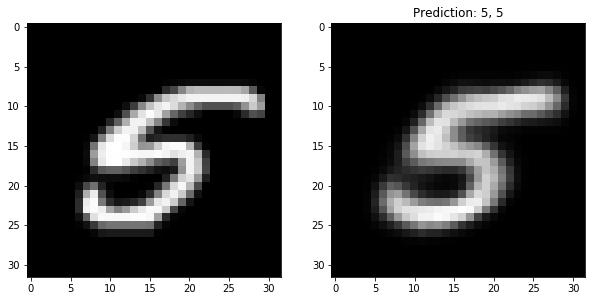

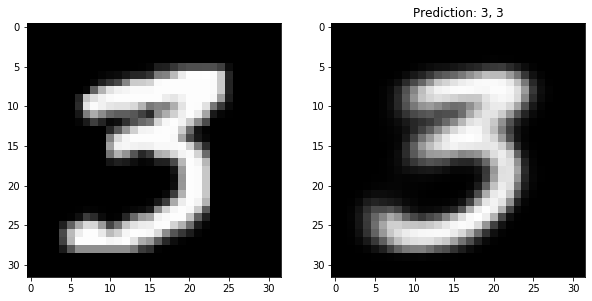

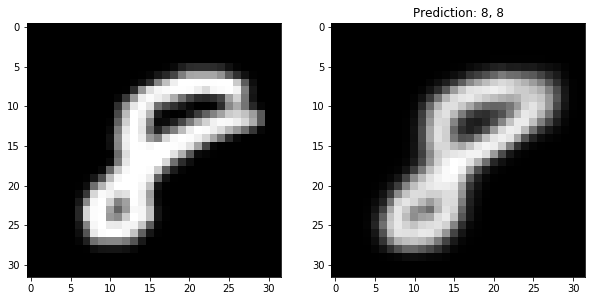

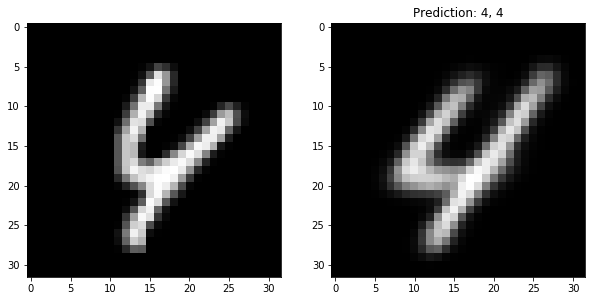

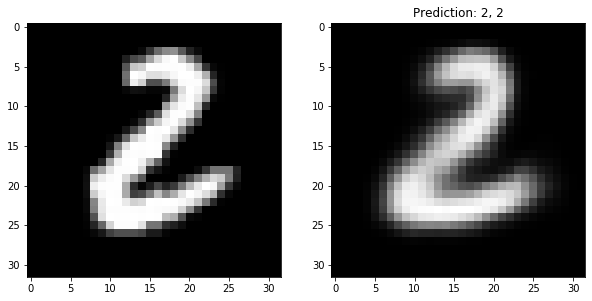

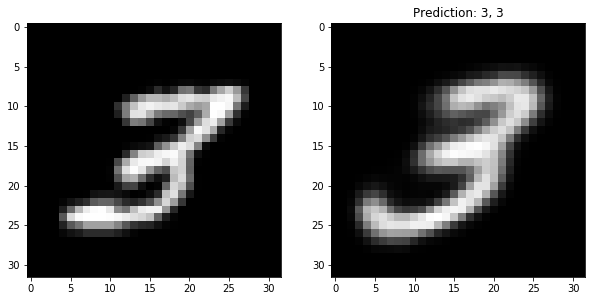

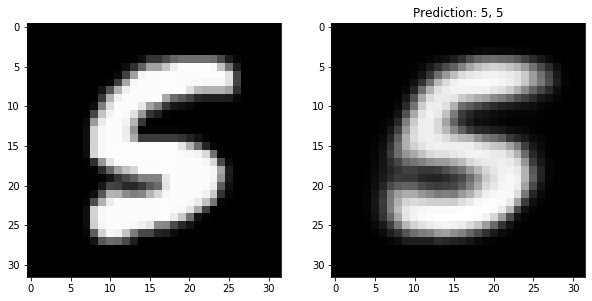

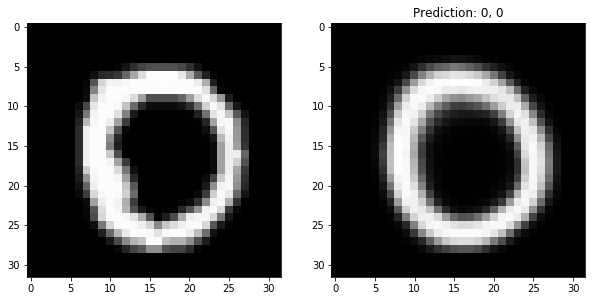

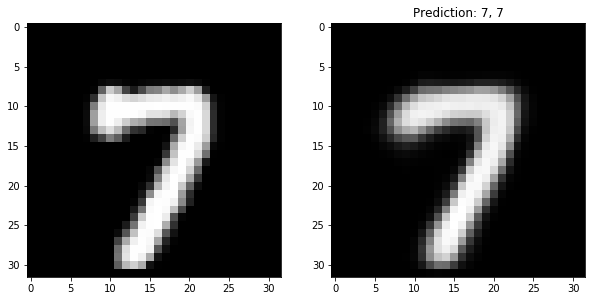

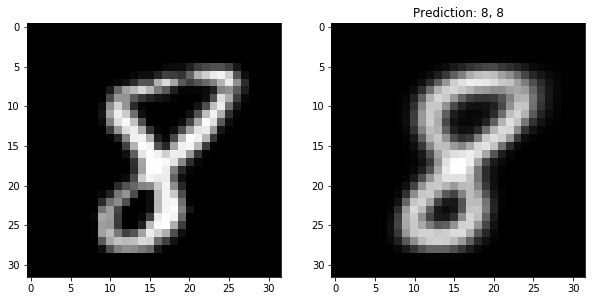

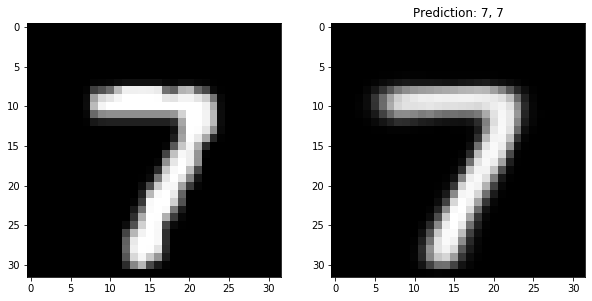

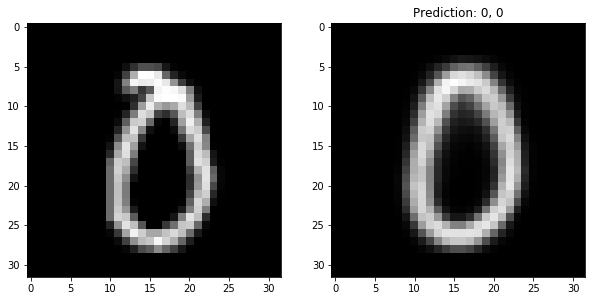

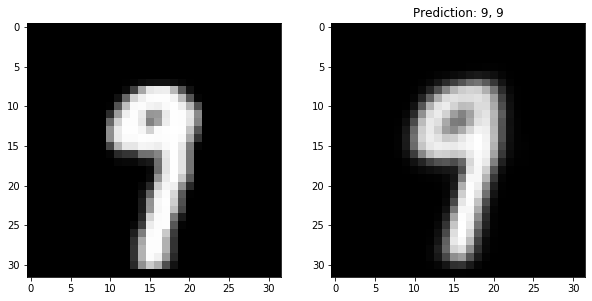

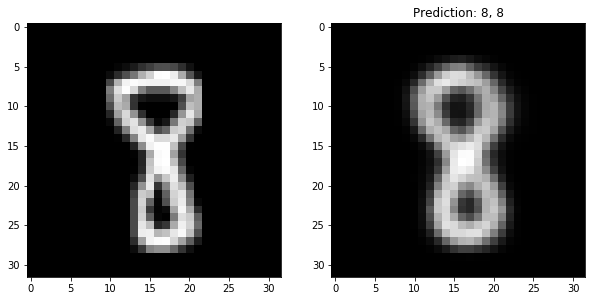

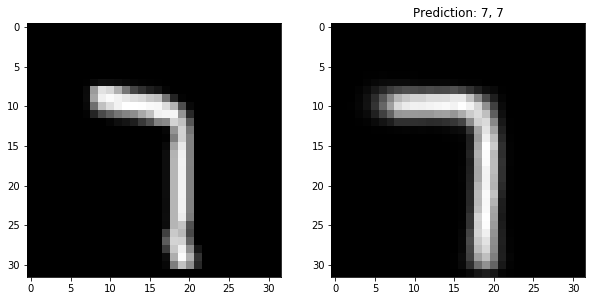

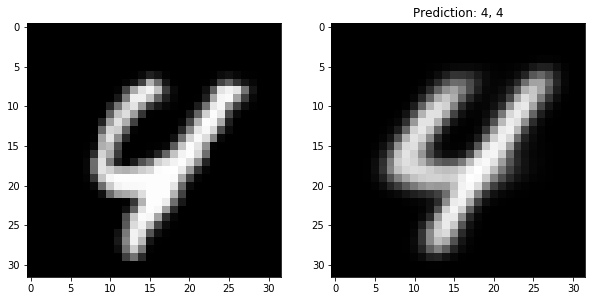

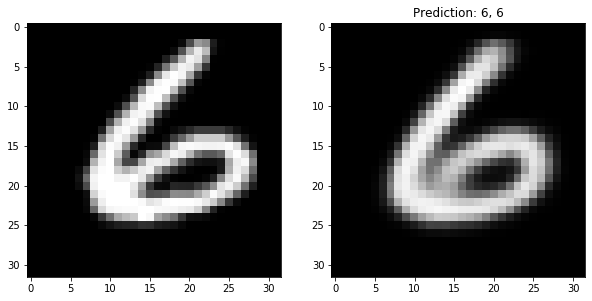

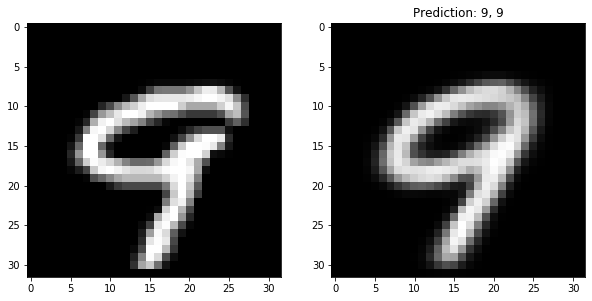

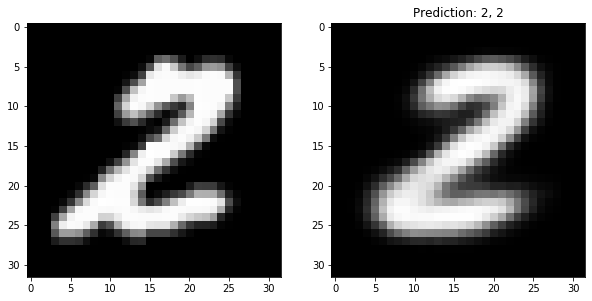

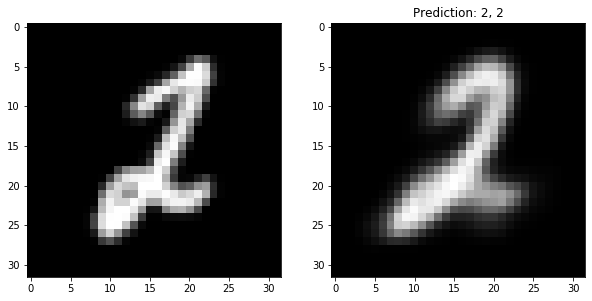

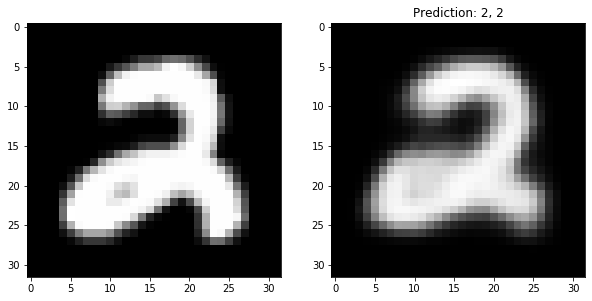

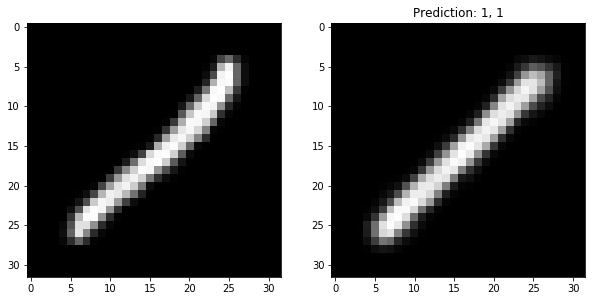

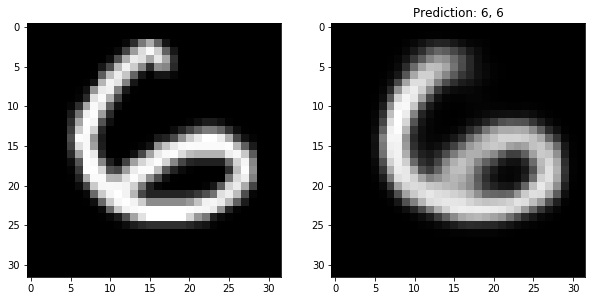

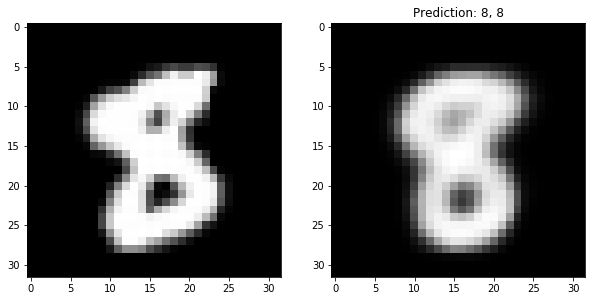

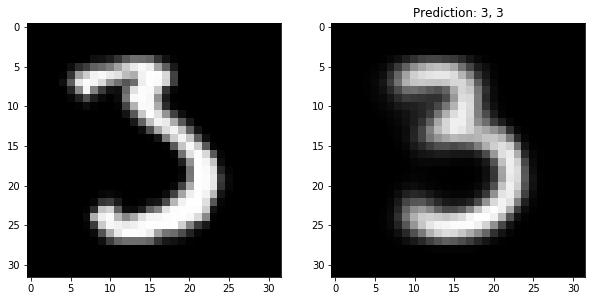

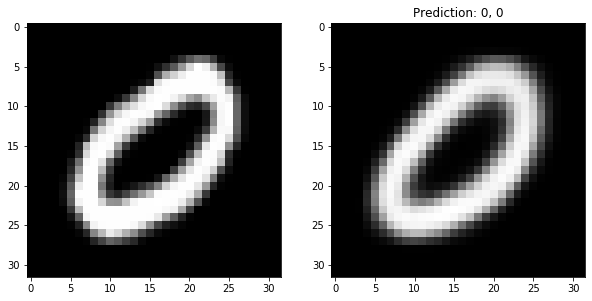

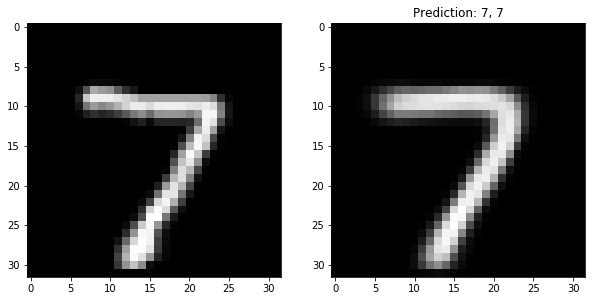

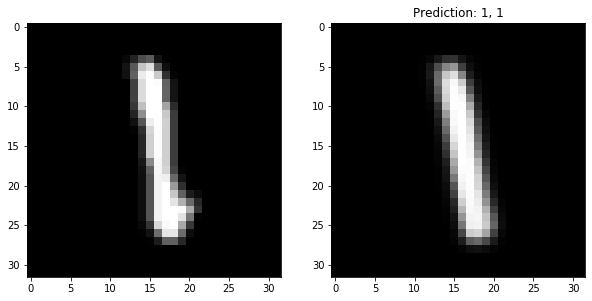

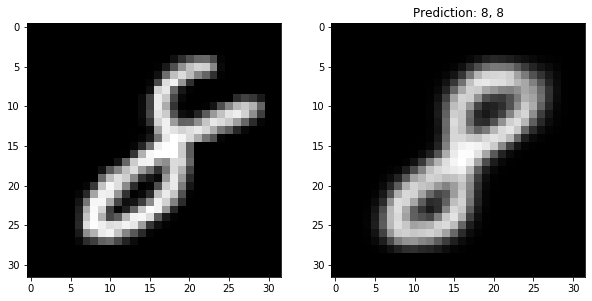

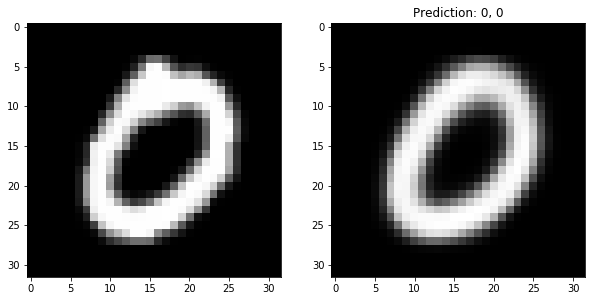

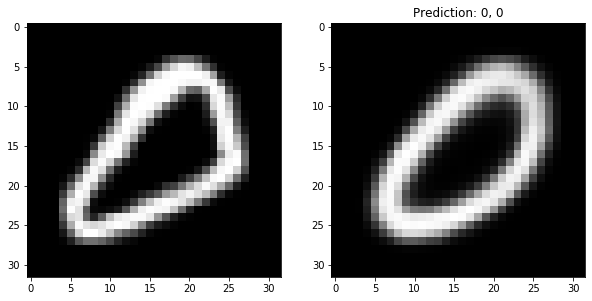

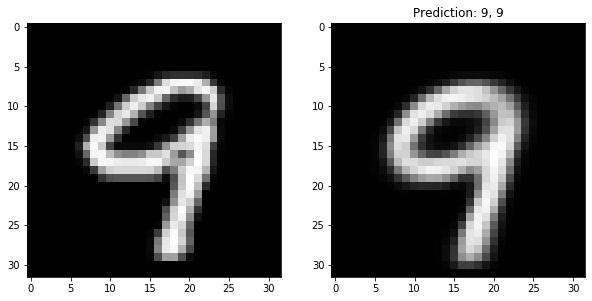

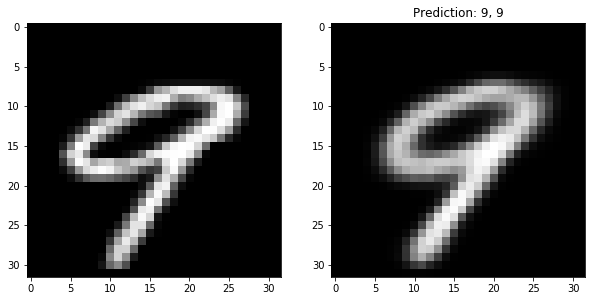

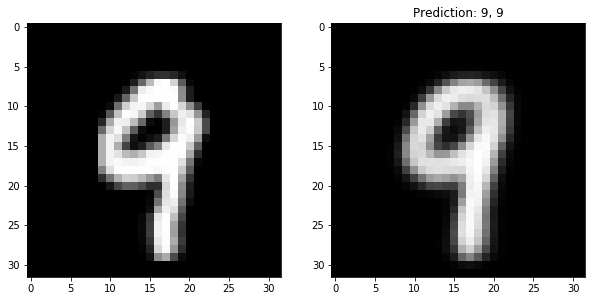

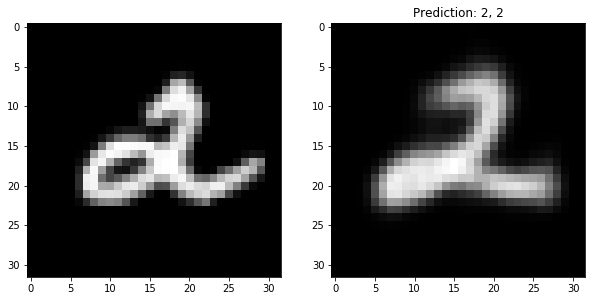

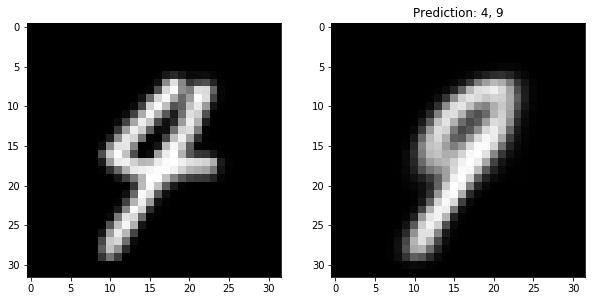

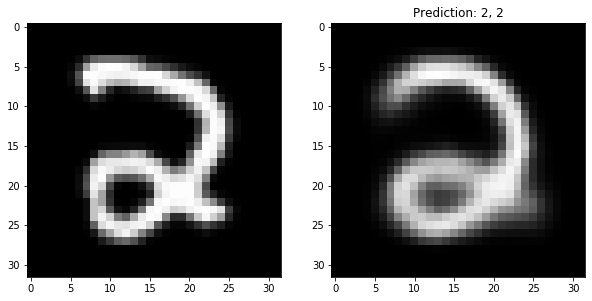

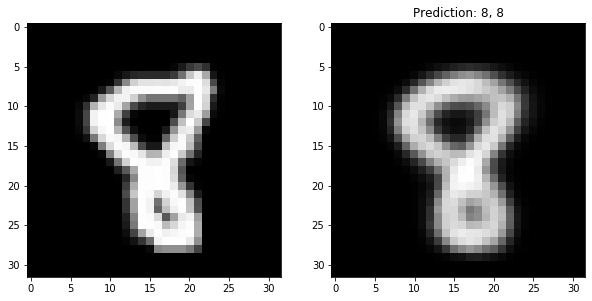

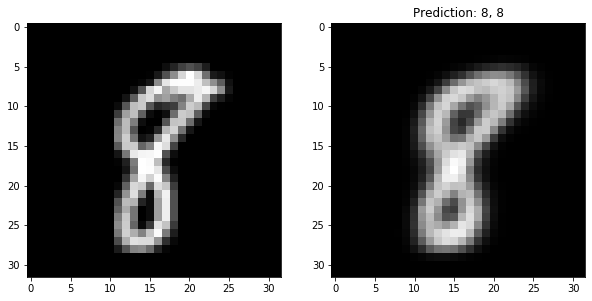

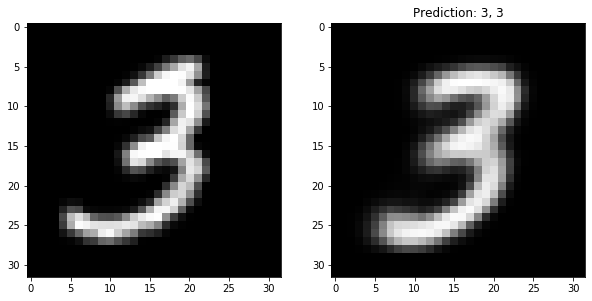

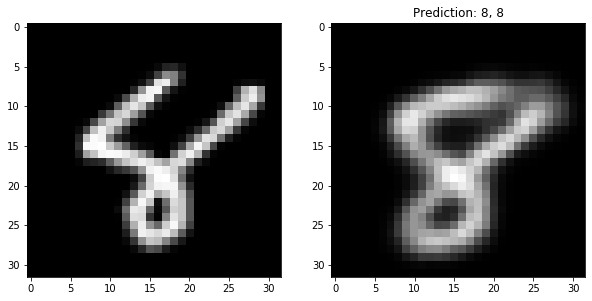

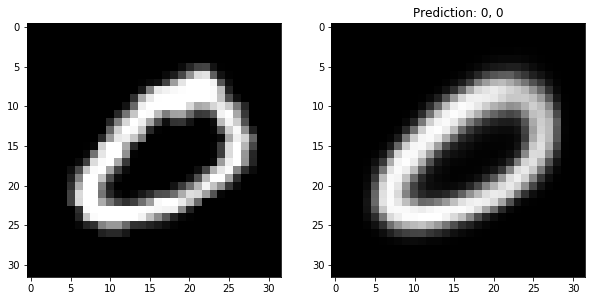

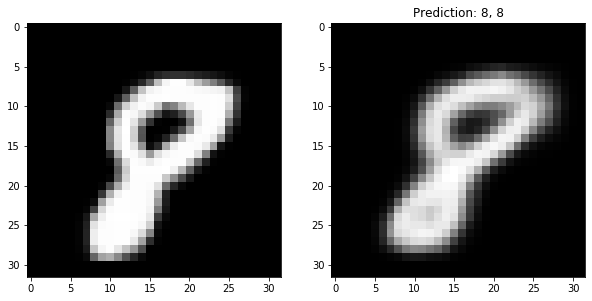

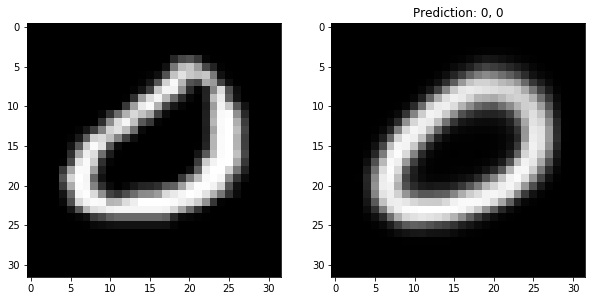

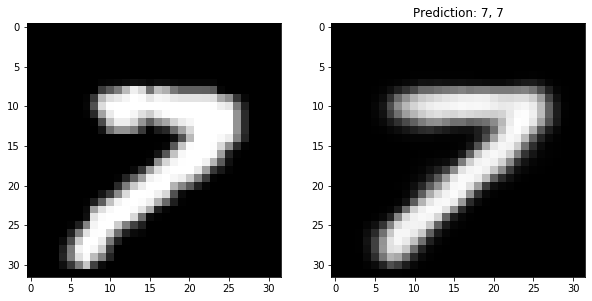

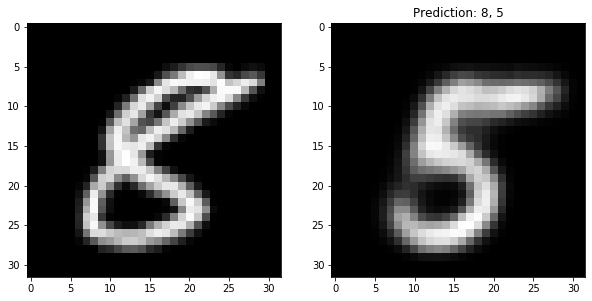

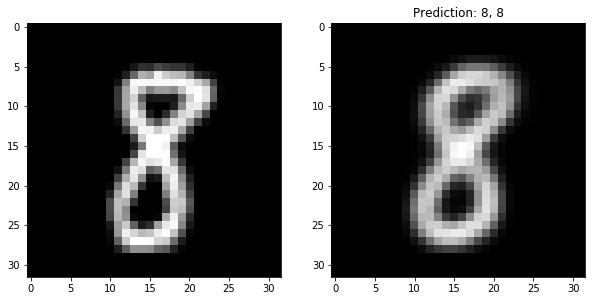

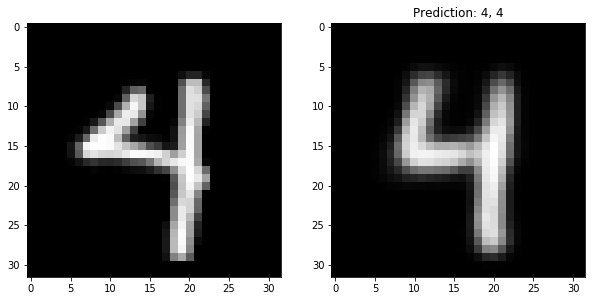

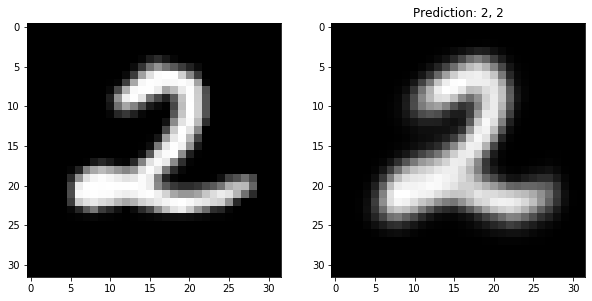

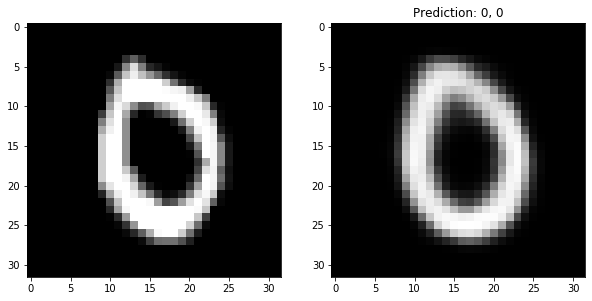

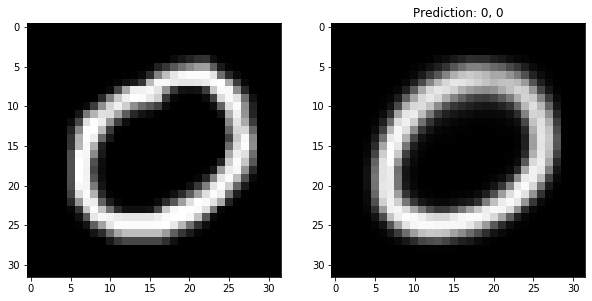

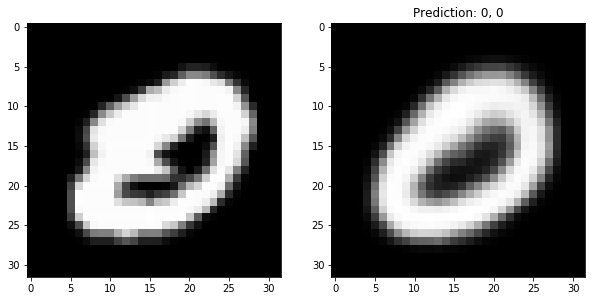

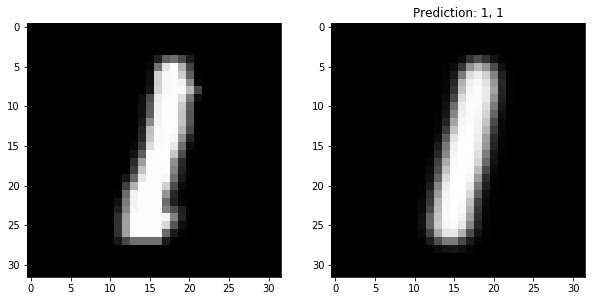

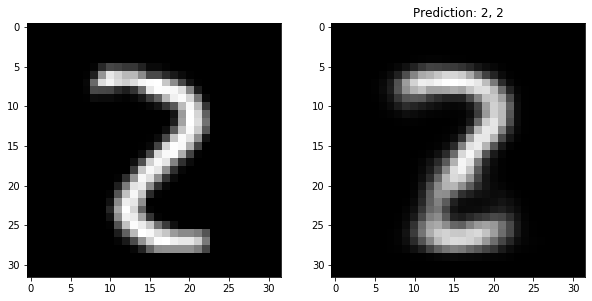

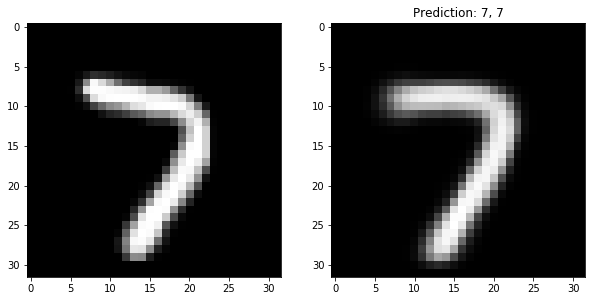

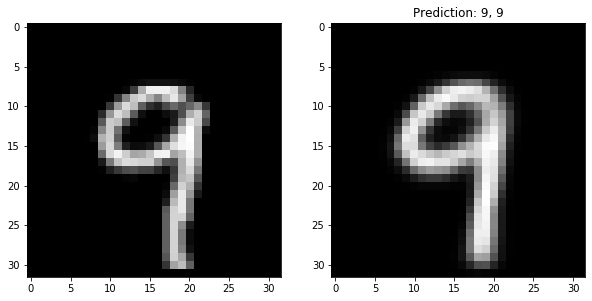

In [156]:
for i in range(64):
    test(i)

In [ ]:
torch.transpose(torch.clamp(coff[:,None].cuda(), min=-0.8, max=0.3)*self.avg_latent.T, 1, 2).sum(1)